In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:32 - loss: 0.2671 - STD: 1.0773e-04 - MAE: 0.5074

 4/74 [>.............................] - ETA: 2s - loss: 0.0917 - STD: 4.2034e-04 - MAE: 0.2351  

 5/74 [=>............................] - ETA: 2s - loss: 0.0772 - STD: 3.7432e-04 - MAE: 0.2090

 6/74 [=>............................] - ETA: 2s - loss: 0.0683 - STD: 3.3000e-04 - MAE: 0.1948

 7/74 [=>............................] - ETA: 3s - loss: 0.0625 - STD: 2.9224e-04 - MAE: 0.1864

 8/74 [==>...........................] - ETA: 3s - loss: 0.0585 - STD: 2.6090e-04 - MAE: 0.1813

 9/74 [==>...........................] - ETA: 3s - loss: 0.0555 - STD: 2.3505e-04 - MAE: 0.1778

10/74 [===>..........................] - ETA: 3s - loss: 0.0532 - STD: 2.1345e-04 - MAE: 0.1753

11/74 [===>..........................] - ETA: 3s - loss: 0.0513 - STD: 1.9527e-04 - MAE: 0.1732

12/74 [===>..........................] - ETA: 3s - loss: 0.0498 - STD: 1.7978e-04 - MAE: 0.1717

13/74 [====>.........................] - ETA: 3s - loss: 0.0485 - STD: 1.6653e-04 - MAE: 0.1703

14/74 [====>.........................] - ETA: 3s - loss: 0.0474 - STD: 1.5512e-04 - MAE: 0.1691

15/74 [=====>........................] - ETA: 3s - loss: 0.0463 - STD: 1.4525e-04 - MAE: 0.1678

16/74 [=====>........................] - ETA: 3s - loss: 0.0454 - STD: 1.3667e-04 - MAE: 0.1666

17/74 [=====>........................] - ETA: 3s - loss: 0.0444 - STD: 1.2919e-04 - MAE: 0.1652

18/74 [======>.......................] - ETA: 5s - loss: 0.0440 - STD: 1.2261e-04 - MAE: 0.1638

22/74 [=======>......................] - ETA: 4s - loss: 0.0405 - STD: 1.0357e-04 - MAE: 0.1572

23/74 [========>.....................] - ETA: 3s - loss: 0.0396 - STD: 1.0027e-04 - MAE: 0.1552

24/74 [========>.....................] - ETA: 3s - loss: 0.0387 - STD: 9.7478e-05 - MAE: 0.1529

25/74 [=========>....................] - ETA: 3s - loss: 0.0377 - STD: 9.5115e-05 - MAE: 0.1504

26/74 [=========>....................] - ETA: 3s - loss: 0.0368 - STD: 9.3125e-05 - MAE: 0.1479

27/74 [=========>....................] - ETA: 3s - loss: 0.0358 - STD: 9.1426e-05 - MAE: 0.1453

28/74 [==========>...................] - ETA: 3s - loss: 0.0349 - STD: 9.0036e-05 - MAE: 0.1428

29/74 [==========>...................] - ETA: 3s - loss: 0.0340 - STD: 8.8799e-05 - MAE: 0.1405

30/74 [===========>..................] - ETA: 3s - loss: 0.0331 - STD: 8.7639e-05 - MAE: 0.1383

31/74 [===========>..................] - ETA: 3s - loss: 0.0324 - STD: 8.6520e-05 - MAE: 0.1365

32/74 [===========>..................] - ETA: 3s - loss: 0.0317 - STD: 8.5367e-05 - MAE: 0.1350

33/74 [============>.................] - ETA: 3s - loss: 0.0311 - STD: 8.4197e-05 - MAE: 0.1337

34/74 [============>.................] - ETA: 2s - loss: 0.0305 - STD: 8.2975e-05 - MAE: 0.1325

35/74 [=============>................] - ETA: 2s - loss: 0.0300 - STD: 8.1718e-05 - MAE: 0.1315

36/74 [=============>................] - ETA: 2s - loss: 0.0295 - STD: 8.0448e-05 - MAE: 0.1305

37/74 [==============>...............] - ETA: 2s - loss: 0.0290 - STD: 7.9213e-05 - MAE: 0.1295

38/74 [==============>...............] - ETA: 2s - loss: 0.0285 - STD: 7.8020e-05 - MAE: 0.1284

39/74 [==============>...............] - ETA: 2s - loss: 0.0281 - STD: 7.6820e-05 - MAE: 0.1272

40/74 [===============>..............] - ETA: 2s - loss: 0.0276 - STD: 7.5691e-05 - MAE: 0.1261

41/74 [===============>..............] - ETA: 2s - loss: 0.0271 - STD: 7.4567e-05 - MAE: 0.1248

42/74 [================>.............] - ETA: 2s - loss: 0.0267 - STD: 7.3436e-05 - MAE: 0.1237

43/74 [================>.............] - ETA: 2s - loss: 0.0263 - STD: 7.2281e-05 - MAE: 0.1225

44/74 [================>.............] - ETA: 2s - loss: 0.0259 - STD: 7.1172e-05 - MAE: 0.1214

45/74 [=================>............] - ETA: 2s - loss: 0.0255 - STD: 7.0098e-05 - MAE: 0.1204

46/74 [=================>............] - ETA: 2s - loss: 0.0252 - STD: 6.9025e-05 - MAE: 0.1194

47/74 [==================>...........] - ETA: 1s - loss: 0.0249 - STD: 6.7996e-05 - MAE: 0.1184

48/74 [==================>...........] - ETA: 1s - loss: 0.0246 - STD: 6.7019e-05 - MAE: 0.1175

49/74 [==================>...........] - ETA: 1s - loss: 0.0243 - STD: 6.6039e-05 - MAE: 0.1166

50/74 [===================>..........] - ETA: 1s - loss: 0.0240 - STD: 6.5074e-05 - MAE: 0.1157

51/74 [===================>..........] - ETA: 1s - loss: 0.0237 - STD: 6.4214e-05 - MAE: 0.1149

52/74 [====================>.........] - ETA: 1s - loss: 0.0234 - STD: 6.3386e-05 - MAE: 0.1141

53/74 [====================>.........] - ETA: 1s - loss: 0.0231 - STD: 6.2611e-05 - MAE: 0.1133

54/74 [====================>.........] - ETA: 1s - loss: 0.0229 - STD: 6.1878e-05 - MAE: 0.1126

55/74 [=====================>........] - ETA: 1s - loss: 0.0226 - STD: 6.1151e-05 - MAE: 0.1119

56/74 [=====================>........] - ETA: 1s - loss: 0.0224 - STD: 6.0454e-05 - MAE: 0.1113

57/74 [======================>.......] - ETA: 1s - loss: 0.0222 - STD: 5.9831e-05 - MAE: 0.1106

58/74 [======================>.......] - ETA: 1s - loss: 0.0219 - STD: 5.9160e-05 - MAE: 0.1101

59/74 [======================>.......] - ETA: 1s - loss: 0.0217 - STD: 5.8555e-05 - MAE: 0.1095

60/74 [=======================>......] - ETA: 0s - loss: 0.0215 - STD: 5.7983e-05 - MAE: 0.1090

61/74 [=======================>......] - ETA: 0s - loss: 0.0213 - STD: 5.7427e-05 - MAE: 0.1085

62/74 [========================>.....] - ETA: 0s - loss: 0.0211 - STD: 5.6874e-05 - MAE: 0.1080

63/74 [========================>.....] - ETA: 0s - loss: 0.0209 - STD: 5.6365e-05 - MAE: 0.1076

64/74 [========================>.....] - ETA: 0s - loss: 0.0208 - STD: 5.5868e-05 - MAE: 0.1071

65/74 [=========================>....] - ETA: 0s - loss: 0.0206 - STD: 5.5370e-05 - MAE: 0.1066

66/74 [=========================>....] - ETA: 0s - loss: 0.0204 - STD: 5.4926e-05 - MAE: 0.1062

67/74 [==========================>...] - ETA: 0s - loss: 0.0202 - STD: 5.4475e-05 - MAE: 0.1057

68/74 [==========================>...] - ETA: 0s - loss: 0.0201 - STD: 5.4017e-05 - MAE: 0.1053

69/74 [==========================>...] - ETA: 0s - loss: 0.0199 - STD: 5.3570e-05 - MAE: 0.1049

70/74 [===========================>..] - ETA: 0s - loss: 0.0198 - STD: 5.3179e-05 - MAE: 0.1044

71/74 [===========================>..] - ETA: 0s - loss: 0.0196 - STD: 5.2784e-05 - MAE: 0.1040

72/74 [============================>.] - ETA: 0s - loss: 0.0195 - STD: 5.2401e-05 - MAE: 0.1036

73/74 [============================>.] - ETA: 0s - loss: 0.0193 - STD: 5.2033e-05 - MAE: 0.1032

74/74 [==============================] - ETA: 0s - loss: 0.0192 - STD: 5.1682e-05 - MAE: 0.1028

74/74 [==============================] - 7s 79ms/step - loss: 0.0192 - STD: 5.1682e-05 - MAE: 0.1028 - val_loss: 0.0086 - val_STD: 1.8940e-05 - val_MAE: 0.0709


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0091 - STD: 2.5698e-05 - MAE: 0.0734

 2/74 [..............................] - ETA: 5s - loss: 0.0093 - STD: 2.6124e-05 - MAE: 0.0744

 3/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 2.6559e-05 - MAE: 0.0742

 4/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 2.6715e-05 - MAE: 0.0741

 5/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 2.6940e-05 - MAE: 0.0742

 6/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 2.6993e-05 - MAE: 0.0744

 7/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 2.6997e-05 - MAE: 0.0745

 8/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 2.7109e-05 - MAE: 0.0746

 9/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 2.7297e-05 - MAE: 0.0747

10/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 2.7444e-05 - MAE: 0.0748

11/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 2.7505e-05 - MAE: 0.0749

12/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 2.7618e-05 - MAE: 0.0749

13/74 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 2.7787e-05 - MAE: 0.0749

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 2.7961e-05 - MAE: 0.0751

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.8204e-05 - MAE: 0.0751

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.8486e-05 - MAE: 0.0752

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.8643e-05 - MAE: 0.0752

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.8800e-05 - MAE: 0.0752

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.8972e-05 - MAE: 0.0752

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.9123e-05 - MAE: 0.0752

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.9300e-05 - MAE: 0.0752

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.9495e-05 - MAE: 0.0752

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 2.9692e-05 - MAE: 0.0753

24/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 2.9914e-05 - MAE: 0.0753

25/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 3.0149e-05 - MAE: 0.0753

26/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 3.0377e-05 - MAE: 0.0753

27/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 3.0591e-05 - MAE: 0.0753

28/74 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 3.0802e-05 - MAE: 0.0753

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 3.1044e-05 - MAE: 0.0753

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.1239e-05 - MAE: 0.0753

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.1445e-05 - MAE: 0.0753

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.1674e-05 - MAE: 0.0753

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 3.1944e-05 - MAE: 0.0754

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 3.2198e-05 - MAE: 0.0754

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 3.2460e-05 - MAE: 0.0753

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 3.2721e-05 - MAE: 0.0753

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 3.2967e-05 - MAE: 0.0754

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 3.3224e-05 - MAE: 0.0754

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 3.3502e-05 - MAE: 0.0754

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 3.3780e-05 - MAE: 0.0754

41/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 3.4062e-05 - MAE: 0.0754

42/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 3.4368e-05 - MAE: 0.0754

43/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 3.4673e-05 - MAE: 0.0754

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 3.4987e-05 - MAE: 0.0754

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 3.5300e-05 - MAE: 0.0754

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 3.5623e-05 - MAE: 0.0754

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 3.5942e-05 - MAE: 0.0754

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 3.6286e-05 - MAE: 0.0754

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 3.6644e-05 - MAE: 0.0754

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 3.7004e-05 - MAE: 0.0754

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 3.7372e-05 - MAE: 0.0754

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 3.7725e-05 - MAE: 0.0754

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 3.8083e-05 - MAE: 0.0754

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.8816e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.9188e-05 - MAE: 0.0754

57/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 3.9567e-05 - MAE: 0.0754

58/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 3.9942e-05 - MAE: 0.0754

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 4.0333e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 4.0729e-05 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 4.1126e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 4.1518e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 4.1903e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 4.2302e-05 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 4.2714e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 4.3128e-05 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 4.3547e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 4.3973e-05 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 4.4410e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 4.4843e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 4.5297e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 4.5752e-05 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 4.6216e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 4.6689e-05 - MAE: 0.0754

74/74 [==============================] - 5s 69ms/step - loss: 0.0092 - STD: 4.6689e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 5.1405e-05 - val_MAE: 0.0714


Epoch 3/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0092 - STD: 8.1840e-05 - MAE: 0.0753

 2/74 [..............................] - ETA: 4s - loss: 0.0093 - STD: 8.2740e-05 - MAE: 0.0754

 3/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 8.3677e-05 - MAE: 0.0755

 4/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 8.4900e-05 - MAE: 0.0753

 5/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 8.5705e-05 - MAE: 0.0756

 6/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 8.6718e-05 - MAE: 0.0755

 7/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 8.7390e-05 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 8.9515e-05 - MAE: 0.0758

10/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 9.0492e-05 - MAE: 0.0758

11/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 9.1392e-05 - MAE: 0.0758

12/74 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 9.2289e-05 - MAE: 0.0758

13/74 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 9.3303e-05 - MAE: 0.0758

14/74 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 9.4259e-05 - MAE: 0.0757

15/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 9.5249e-05 - MAE: 0.0757

16/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 9.6338e-05 - MAE: 0.0757

17/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 9.7394e-05 - MAE: 0.0757

18/74 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 9.8486e-05 - MAE: 0.0757

19/74 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 9.9574e-05 - MAE: 0.0757

20/74 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 1.0061e-04 - MAE: 0.0756

21/74 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 1.0171e-04 - MAE: 0.0756

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.0285e-04 - MAE: 0.0756

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.0406e-04 - MAE: 0.0755

24/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.0526e-04 - MAE: 0.0755

25/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 1.0652e-04 - MAE: 0.0755

26/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 1.0783e-04 - MAE: 0.0755

27/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.0907e-04 - MAE: 0.0754

28/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.1040e-04 - MAE: 0.0754

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.1180e-04 - MAE: 0.0754

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.1314e-04 - MAE: 0.0754

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.1456e-04 - MAE: 0.0754

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.1596e-04 - MAE: 0.0754

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.1744e-04 - MAE: 0.0754

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.1890e-04 - MAE: 0.0754

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.2047e-04 - MAE: 0.0754

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.2204e-04 - MAE: 0.0754

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.2364e-04 - MAE: 0.0755

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.2524e-04 - MAE: 0.0755

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.2691e-04 - MAE: 0.0755

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 1.2861e-04 - MAE: 0.0755

41/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 1.3037e-04 - MAE: 0.0755

42/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 1.3214e-04 - MAE: 0.0755

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.3398e-04 - MAE: 0.0754

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.3579e-04 - MAE: 0.0754

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.3762e-04 - MAE: 0.0755

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.3950e-04 - MAE: 0.0755

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.4145e-04 - MAE: 0.0755

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.4344e-04 - MAE: 0.0754

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.4551e-04 - MAE: 0.0754

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.4763e-04 - MAE: 0.0754

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.4974e-04 - MAE: 0.0754

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.5187e-04 - MAE: 0.0754

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.5410e-04 - MAE: 0.0754

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.5636e-04 - MAE: 0.0754

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.5869e-04 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.6108e-04 - MAE: 0.0754

57/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 1.6352e-04 - MAE: 0.0754

58/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 1.6602e-04 - MAE: 0.0754

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.6861e-04 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.7115e-04 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.7384e-04 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.7658e-04 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.7942e-04 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.8228e-04 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.8521e-04 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.8821e-04 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.9126e-04 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.9437e-04 - MAE: 0.0753

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.9754e-04 - MAE: 0.0753

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 2.0081e-04 - MAE: 0.0753

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 2.0416e-04 - MAE: 0.0753

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 2.0760e-04 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 2.1110e-04 - MAE: 0.0753

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 2.1466e-04 - MAE: 0.0753

74/74 [==============================] - 5s 68ms/step - loss: 0.0092 - STD: 2.1466e-04 - MAE: 0.0753 - val_loss: 0.0086 - val_STD: 3.1305e-04 - val_MAE: 0.0715


Epoch 4/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0094 - STD: 4.9638e-04 - MAE: 0.0765

 2/74 [..............................] - ETA: 5s - loss: 0.0094 - STD: 5.0288e-04 - MAE: 0.0761

 3/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 5.0860e-04 - MAE: 0.0760

 4/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 5.1501e-04 - MAE: 0.0756

 5/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 5.2241e-04 - MAE: 0.0757

 6/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 5.3076e-04 - MAE: 0.0758

 7/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 5.3894e-04 - MAE: 0.0758

 8/74 [==>...........................] - ETA: 4s - loss: 0.0093 - STD: 5.4709e-04 - MAE: 0.0758

 9/74 [==>...........................] - ETA: 4s - loss: 0.0093 - STD: 5.5622e-04 - MAE: 0.0758

10/74 [===>..........................] - ETA: 4s - loss: 0.0093 - STD: 5.6516e-04 - MAE: 0.0757

11/74 [===>..........................] - ETA: 4s - loss: 0.0093 - STD: 5.7348e-04 - MAE: 0.0756

12/74 [===>..........................] - ETA: 4s - loss: 0.0093 - STD: 5.8299e-04 - MAE: 0.0757

13/74 [====>.........................] - ETA: 4s - loss: 0.0093 - STD: 5.9240e-04 - MAE: 0.0756

14/74 [====>.........................] - ETA: 4s - loss: 0.0092 - STD: 6.0226e-04 - MAE: 0.0756

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 6.1295e-04 - MAE: 0.0756

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 6.2304e-04 - MAE: 0.0755

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 6.3396e-04 - MAE: 0.0755

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 6.4481e-04 - MAE: 0.0755

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 6.5589e-04 - MAE: 0.0754

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 6.6753e-04 - MAE: 0.0754

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 6.7889e-04 - MAE: 0.0753

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 6.9084e-04 - MAE: 0.0753

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 7.0361e-04 - MAE: 0.0753

24/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 7.1628e-04 - MAE: 0.0753

25/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 7.2927e-04 - MAE: 0.0752

26/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 7.4294e-04 - MAE: 0.0752

27/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 7.5663e-04 - MAE: 0.0752

28/74 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 7.7046e-04 - MAE: 0.0752

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 7.8485e-04 - MAE: 0.0752

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 7.9977e-04 - MAE: 0.0752

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 8.1526e-04 - MAE: 0.0752

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 8.3102e-04 - MAE: 0.0752

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 8.4725e-04 - MAE: 0.0752

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 8.6395e-04 - MAE: 0.0752

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 8.8155e-04 - MAE: 0.0752

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 8.9944e-04 - MAE: 0.0752

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 9.1817e-04 - MAE: 0.0752

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 9.3710e-04 - MAE: 0.0752

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 9.5702e-04 - MAE: 0.0752

40/74 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 9.7728e-04 - MAE: 0.0752

41/74 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 9.9795e-04 - MAE: 0.0752

42/74 [================>.............] - ETA: 2s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0752    

43/74 [================>.............] - ETA: 2s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0752

44/74 [================>.............] - ETA: 1s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

45/74 [=================>............] - ETA: 1s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

46/74 [=================>............] - ETA: 1s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

47/74 [==================>...........] - ETA: 1s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

48/74 [==================>...........] - ETA: 1s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0751

49/74 [==================>...........] - ETA: 1s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0751

50/74 [===================>..........] - ETA: 1s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0751

51/74 [===================>..........] - ETA: 1s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0751

52/74 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0751

53/74 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0751

54/74 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0751

55/74 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0751

56/74 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0750

57/74 [======================>.......] - ETA: 1s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0750

58/74 [======================>.......] - ETA: 1s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0750

59/74 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0750

60/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0750

61/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0749

62/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0749

63/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0749

65/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0749

66/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0749

67/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0749

68/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0749

69/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0748

70/74 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0020 - MAE: 0.0748

71/74 [===========================>..] - ETA: 0s - loss: 0.0090 - STD: 0.0020 - MAE: 0.0748

72/74 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0021 - MAE: 0.0747

73/74 [============================>.] - ETA: 0s - loss: 0.0090 - STD: 0.0022 - MAE: 0.0747

74/74 [==============================] - ETA: 0s - loss: 0.0090 - STD: 0.0022 - MAE: 0.0747

74/74 [==============================] - 5s 70ms/step - loss: 0.0090 - STD: 0.0022 - MAE: 0.0747 - val_loss: 0.0080 - val_STD: 0.0042 - val_MAE: 0.0693


Epoch 5/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0085 - STD: 0.0067 - MAE: 0.0729

 2/74 [..............................] - ETA: 4s - loss: 0.0086 - STD: 0.0069 - MAE: 0.0733

 3/74 [>.............................] - ETA: 4s - loss: 0.0087 - STD: 0.0070 - MAE: 0.0735

 4/74 [>.............................] - ETA: 4s - loss: 0.0087 - STD: 0.0072 - MAE: 0.0735

 5/74 [=>............................] - ETA: 4s - loss: 0.0087 - STD: 0.0073 - MAE: 0.0734

 6/74 [=>............................] - ETA: 4s - loss: 0.0087 - STD: 0.0075 - MAE: 0.0734

 7/74 [=>............................] - ETA: 4s - loss: 0.0086 - STD: 0.0076 - MAE: 0.0733

 8/74 [==>...........................] - ETA: 4s - loss: 0.0086 - STD: 0.0078 - MAE: 0.0732

 9/74 [==>...........................] - ETA: 4s - loss: 0.0086 - STD: 0.0079 - MAE: 0.0731

10/74 [===>..........................] - ETA: 4s - loss: 0.0086 - STD: 0.0081 - MAE: 0.0730

11/74 [===>..........................] - ETA: 4s - loss: 0.0085 - STD: 0.0083 - MAE: 0.0729

12/74 [===>..........................] - ETA: 3s - loss: 0.0085 - STD: 0.0084 - MAE: 0.0728

13/74 [====>.........................] - ETA: 3s - loss: 0.0085 - STD: 0.0086 - MAE: 0.0727

14/74 [====>.........................] - ETA: 3s - loss: 0.0085 - STD: 0.0088 - MAE: 0.0727

15/74 [=====>........................] - ETA: 3s - loss: 0.0085 - STD: 0.0089 - MAE: 0.0726

16/74 [=====>........................] - ETA: 3s - loss: 0.0085 - STD: 0.0091 - MAE: 0.0726

17/74 [=====>........................] - ETA: 3s - loss: 0.0085 - STD: 0.0093 - MAE: 0.0725

18/74 [======>.......................] - ETA: 3s - loss: 0.0085 - STD: 0.0095 - MAE: 0.0724

19/74 [======>.......................] - ETA: 3s - loss: 0.0084 - STD: 0.0097 - MAE: 0.0724

20/74 [=======>......................] - ETA: 3s - loss: 0.0084 - STD: 0.0099 - MAE: 0.0724

21/74 [=======>......................] - ETA: 3s - loss: 0.0084 - STD: 0.0101 - MAE: 0.0723

22/74 [=======>......................] - ETA: 3s - loss: 0.0084 - STD: 0.0103 - MAE: 0.0722

23/74 [========>.....................] - ETA: 3s - loss: 0.0084 - STD: 0.0106 - MAE: 0.0721

24/74 [========>.....................] - ETA: 3s - loss: 0.0084 - STD: 0.0108 - MAE: 0.0720

25/74 [=========>....................] - ETA: 3s - loss: 0.0083 - STD: 0.0110 - MAE: 0.0720

26/74 [=========>....................] - ETA: 3s - loss: 0.0083 - STD: 0.0112 - MAE: 0.0719

27/74 [=========>....................] - ETA: 3s - loss: 0.0083 - STD: 0.0115 - MAE: 0.0719

28/74 [==========>...................] - ETA: 2s - loss: 0.0083 - STD: 0.0117 - MAE: 0.0718

29/74 [==========>...................] - ETA: 2s - loss: 0.0083 - STD: 0.0120 - MAE: 0.0718

30/74 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.0122 - MAE: 0.0717

31/74 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.0125 - MAE: 0.0717

32/74 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.0127 - MAE: 0.0716

33/74 [============>.................] - ETA: 2s - loss: 0.0082 - STD: 0.0130 - MAE: 0.0715

34/74 [============>.................] - ETA: 2s - loss: 0.0082 - STD: 0.0132 - MAE: 0.0714

35/74 [=============>................] - ETA: 2s - loss: 0.0082 - STD: 0.0135 - MAE: 0.0713

36/74 [=============>................] - ETA: 2s - loss: 0.0082 - STD: 0.0138 - MAE: 0.0713

37/74 [==============>...............] - ETA: 2s - loss: 0.0082 - STD: 0.0141 - MAE: 0.0712

38/74 [==============>...............] - ETA: 2s - loss: 0.0082 - STD: 0.0143 - MAE: 0.0712

39/74 [==============>...............] - ETA: 2s - loss: 0.0081 - STD: 0.0146 - MAE: 0.0711

40/74 [===============>..............] - ETA: 2s - loss: 0.0081 - STD: 0.0149 - MAE: 0.0710

41/74 [===============>..............] - ETA: 2s - loss: 0.0081 - STD: 0.0152 - MAE: 0.0710

42/74 [================>.............] - ETA: 2s - loss: 0.0081 - STD: 0.0155 - MAE: 0.0709

43/74 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0158 - MAE: 0.0708

44/74 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0161 - MAE: 0.0707

45/74 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.0164 - MAE: 0.0706

46/74 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.0167 - MAE: 0.0705

47/74 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.0170 - MAE: 0.0705

48/74 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.0173 - MAE: 0.0704

49/74 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.0176 - MAE: 0.0703

51/74 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.0182 - MAE: 0.0702

52/74 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.0185 - MAE: 0.0701

53/74 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.0188 - MAE: 0.0700

54/74 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.0191 - MAE: 0.0699

55/74 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.0194 - MAE: 0.0698

56/74 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.0197 - MAE: 0.0697

57/74 [======================>.......] - ETA: 1s - loss: 0.0079 - STD: 0.0200 - MAE: 0.0697

58/74 [======================>.......] - ETA: 1s - loss: 0.0078 - STD: 0.0203 - MAE: 0.0696

59/74 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.0206 - MAE: 0.0695

60/74 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.0209 - MAE: 0.0694

61/74 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.0212 - MAE: 0.0693

62/74 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.0215 - MAE: 0.0692

63/74 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0218 - MAE: 0.0691

64/74 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0221 - MAE: 0.0690

65/74 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0224 - MAE: 0.0689

66/74 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0227 - MAE: 0.0688

67/74 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.0230 - MAE: 0.0687

68/74 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.0233 - MAE: 0.0686

69/74 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.0236 - MAE: 0.0685

70/74 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0239 - MAE: 0.0685

71/74 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0242 - MAE: 0.0684

72/74 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0244 - MAE: 0.0683

73/74 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.0247 - MAE: 0.0681

74/74 [==============================] - ETA: 0s - loss: 0.0075 - STD: 0.0250 - MAE: 0.0681

74/74 [==============================] - 5s 68ms/step - loss: 0.0075 - STD: 0.0250 - MAE: 0.0681 - val_loss: 0.0053 - val_STD: 0.0344 - val_MAE: 0.0560


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0062 - STD: 0.0472 - MAE: 0.0614

 2/74 [..............................] - ETA: 5s - loss: 0.0061 - STD: 0.0469 - MAE: 0.0608

 3/74 [>.............................] - ETA: 4s - loss: 0.0061 - STD: 0.0472 - MAE: 0.0608

 4/74 [>.............................] - ETA: 4s - loss: 0.0061 - STD: 0.0476 - MAE: 0.0608

 5/74 [=>............................] - ETA: 4s - loss: 0.0061 - STD: 0.0479 - MAE: 0.0608

 6/74 [=>............................] - ETA: 4s - loss: 0.0061 - STD: 0.0480 - MAE: 0.0606

 7/74 [=>............................] - ETA: 4s - loss: 0.0061 - STD: 0.0481 - MAE: 0.0604

 8/74 [==>...........................] - ETA: 4s - loss: 0.0061 - STD: 0.0484 - MAE: 0.0603

 9/74 [==>...........................] - ETA: 4s - loss: 0.0061 - STD: 0.0486 - MAE: 0.0604

10/74 [===>..........................] - ETA: 4s - loss: 0.0060 - STD: 0.0487 - MAE: 0.0603

11/74 [===>..........................] - ETA: 4s - loss: 0.0060 - STD: 0.0488 - MAE: 0.0602

12/74 [===>..........................] - ETA: 4s - loss: 0.0060 - STD: 0.0490 - MAE: 0.0602

13/74 [====>.........................] - ETA: 4s - loss: 0.0060 - STD: 0.0492 - MAE: 0.0601

14/74 [====>.........................] - ETA: 4s - loss: 0.0060 - STD: 0.0493 - MAE: 0.0600

15/74 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.0494 - MAE: 0.0599

16/74 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.0496 - MAE: 0.0599

17/74 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.0498 - MAE: 0.0598

18/74 [======>.......................] - ETA: 3s - loss: 0.0060 - STD: 0.0498 - MAE: 0.0597

19/74 [======>.......................] - ETA: 3s - loss: 0.0059 - STD: 0.0499 - MAE: 0.0597

20/74 [=======>......................] - ETA: 3s - loss: 0.0059 - STD: 0.0501 - MAE: 0.0597

21/74 [=======>......................] - ETA: 3s - loss: 0.0059 - STD: 0.0502 - MAE: 0.0596

22/74 [=======>......................] - ETA: 3s - loss: 0.0059 - STD: 0.0503 - MAE: 0.0595

23/74 [========>.....................] - ETA: 3s - loss: 0.0059 - STD: 0.0504 - MAE: 0.0594

24/74 [========>.....................] - ETA: 3s - loss: 0.0059 - STD: 0.0506 - MAE: 0.0594

25/74 [=========>....................] - ETA: 3s - loss: 0.0059 - STD: 0.0507 - MAE: 0.0593

26/74 [=========>....................] - ETA: 3s - loss: 0.0059 - STD: 0.0508 - MAE: 0.0592

27/74 [=========>....................] - ETA: 3s - loss: 0.0059 - STD: 0.0510 - MAE: 0.0592

28/74 [==========>...................] - ETA: 3s - loss: 0.0059 - STD: 0.0512 - MAE: 0.0591

29/74 [==========>...................] - ETA: 3s - loss: 0.0058 - STD: 0.0512 - MAE: 0.0590

30/74 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0514 - MAE: 0.0590

31/74 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0516 - MAE: 0.0589

32/74 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0516 - MAE: 0.0589

33/74 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0518 - MAE: 0.0588

34/74 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0520 - MAE: 0.0588

35/74 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0520 - MAE: 0.0587

36/74 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0521 - MAE: 0.0586

37/74 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0523 - MAE: 0.0586

39/74 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0524 - MAE: 0.0585

40/74 [===============>..............] - ETA: 2s - loss: 0.0058 - STD: 0.0525 - MAE: 0.0585

41/74 [===============>..............] - ETA: 2s - loss: 0.0057 - STD: 0.0527 - MAE: 0.0584

42/74 [================>.............] - ETA: 2s - loss: 0.0057 - STD: 0.0527 - MAE: 0.0584

43/74 [================>.............] - ETA: 2s - loss: 0.0057 - STD: 0.0528 - MAE: 0.0583

44/74 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0529 - MAE: 0.0583

45/74 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0530 - MAE: 0.0583

46/74 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0531 - MAE: 0.0582

47/74 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0532 - MAE: 0.0582

48/74 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0532 - MAE: 0.0581

49/74 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0534 - MAE: 0.0580

50/74 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0535 - MAE: 0.0580

51/74 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0536 - MAE: 0.0579

52/74 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0537 - MAE: 0.0579

53/74 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0538 - MAE: 0.0578

54/74 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0539 - MAE: 0.0578

55/74 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0539 - MAE: 0.0578

56/74 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0541 - MAE: 0.0577

57/74 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0541 - MAE: 0.0577

58/74 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0542 - MAE: 0.0577

59/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0543 - MAE: 0.0576

60/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0543 - MAE: 0.0576

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0544 - MAE: 0.0576

62/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0545 - MAE: 0.0575

63/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0545 - MAE: 0.0575

64/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0546 - MAE: 0.0575

65/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0547 - MAE: 0.0574

66/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0548 - MAE: 0.0574

67/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0549 - MAE: 0.0573

68/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0550 - MAE: 0.0573

69/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0550 - MAE: 0.0573

70/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0551 - MAE: 0.0573

71/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0552 - MAE: 0.0573

72/74 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0552 - MAE: 0.0572

73/74 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0553 - MAE: 0.0572

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0554 - MAE: 0.0572

74/74 [==============================] - 5s 70ms/step - loss: 0.0055 - STD: 0.0554 - MAE: 0.0572 - val_loss: 0.0044 - val_STD: 0.0484 - val_MAE: 0.0510


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0599 - MAE: 0.0542

 2/74 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0586 - MAE: 0.0542

 3/74 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0591 - MAE: 0.0544

 4/74 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0590 - MAE: 0.0545

 5/74 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0589 - MAE: 0.0546

 6/74 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0592 - MAE: 0.0546

 7/74 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0593 - MAE: 0.0547

 8/74 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0594 - MAE: 0.0547

 9/74 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0547

10/74 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0546

11/74 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0545

12/74 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0545

13/74 [====>.........................] - ETA: 4s - loss: 0.0051 - STD: 0.0601 - MAE: 0.0545

15/74 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0545

16/74 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0544

17/74 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0544

18/74 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0544

19/74 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0544

20/74 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0544

21/74 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0544

22/74 [=======>......................] - ETA: 3s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0544

23/74 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0544

24/74 [========>.....................] - ETA: 3s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0544

25/74 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0544

26/74 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0607 - MAE: 0.0543

27/74 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0608 - MAE: 0.0544

28/74 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.0608 - MAE: 0.0543

29/74 [==========>...................] - ETA: 3s - loss: 0.0050 - STD: 0.0609 - MAE: 0.0544

30/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0609 - MAE: 0.0543

31/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0609 - MAE: 0.0543

32/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0610 - MAE: 0.0542

33/74 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0610 - MAE: 0.0542

34/74 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0610 - MAE: 0.0542

35/74 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0611 - MAE: 0.0542

36/74 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0542

37/74 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0541

38/74 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0541

39/74 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0541

40/74 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0541

41/74 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0541

42/74 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0541

43/74 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0541

44/74 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0541

45/74 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0540

46/74 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0540

47/74 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0540

48/74 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0540

49/74 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0540

50/74 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0540

51/74 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0540

52/74 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0540

53/74 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0539

54/74 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0539

55/74 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0539

56/74 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0539

57/74 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0539

58/74 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0539

59/74 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0539

60/74 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0539

61/74 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0539

62/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0539

63/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0539

64/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0538

65/74 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0538

66/74 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0619 - MAE: 0.0538

67/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0619 - MAE: 0.0538

68/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0620 - MAE: 0.0538

69/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0620 - MAE: 0.0538

70/74 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0620 - MAE: 0.0538

71/74 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0621 - MAE: 0.0537

72/74 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0621 - MAE: 0.0537

73/74 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0621 - MAE: 0.0537

74/74 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0621 - MAE: 0.0537

74/74 [==============================] - 5s 71ms/step - loss: 0.0049 - STD: 0.0621 - MAE: 0.0537 - val_loss: 0.0041 - val_STD: 0.0495 - val_MAE: 0.0483


Epoch 8/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0049 - STD: 0.0598 - MAE: 0.0526

 2/74 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0627 - MAE: 0.0527

 3/74 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0529

 4/74 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0526

 5/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0529

 6/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0528

 7/74 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0527

 8/74 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

 9/74 [==>...........................] - ETA: 4s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0527

10/74 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0527

11/74 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0528

12/74 [===>..........................] - ETA: 4s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0527

13/74 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

14/74 [====>.........................] - ETA: 4s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0527

15/74 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

16/74 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0526

17/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0526

18/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0525

19/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0526

20/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0526

21/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0525

22/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0526

23/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0525

24/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0525

25/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0526

26/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0525

27/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0642 - MAE: 0.0526

28/74 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0526

29/74 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

30/74 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0527

31/74 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0528

32/74 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0528

33/74 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0527

34/74 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0529

35/74 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0529

36/74 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0529

37/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0529

38/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0530

39/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0530

40/74 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0634 - MAE: 0.0529

41/74 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0529

43/74 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0529

44/74 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0529

45/74 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0529

46/74 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0529

47/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0528

48/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0528

49/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0528

50/74 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0528

51/74 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0528

52/74 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

53/74 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

54/74 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0527

55/74 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0527

56/74 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

57/74 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

58/74 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

59/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

60/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

61/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0526

62/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0526

63/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0526

64/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0526

65/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0526

66/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0526

67/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0526

68/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0526

69/74 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0526

70/74 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0526

71/74 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0525

72/74 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0525

73/74 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0525

74/74 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0525

74/74 [==============================] - 5s 70ms/step - loss: 0.0047 - STD: 0.0645 - MAE: 0.0525 - val_loss: 0.0040 - val_STD: 0.0531 - val_MAE: 0.0478


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0046 - STD: 0.0640 - MAE: 0.0504

 2/74 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0509

 3/74 [>.............................] - ETA: 5s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0513

 4/74 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0514

 5/74 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0514

 6/74 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0516

 7/74 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0517

 8/74 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0516

 9/74 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0517

10/74 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

11/74 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0516

12/74 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

13/74 [====>.........................] - ETA: 4s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

14/74 [====>.........................] - ETA: 4s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

15/74 [=====>........................] - ETA: 4s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

16/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

17/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

18/74 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

19/74 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

20/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0515

21/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0514

22/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0514

23/74 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0514

24/74 [========>.....................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0514

25/74 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

26/74 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

27/74 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

28/74 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

29/74 [==========>...................] - ETA: 3s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

30/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

31/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

32/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

33/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

34/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0513

35/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

36/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

37/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

38/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

39/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

40/74 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

41/74 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

42/74 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

43/74 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

44/74 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

46/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

47/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

48/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

49/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

50/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

51/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

52/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

53/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

54/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

55/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0513

56/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0513

57/74 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

58/74 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

59/74 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

60/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0514

61/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0513

62/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0513

63/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0513

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

65/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

74/74 [==============================] - 5s 70ms/step - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513 - val_loss: 0.0039 - val_STD: 0.0548 - val_MAE: 0.0476


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0506

 2/74 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0508

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0507

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0507

 5/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0507

 6/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0507

 7/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0507

 8/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0507

 9/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0670 - MAE: 0.0507

10/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0671 - MAE: 0.0507

11/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0506

12/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0671 - MAE: 0.0506

13/74 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0506

14/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0506

15/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0506

16/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0506

17/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0507

18/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0507

19/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0506

20/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

21/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

22/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0506

23/74 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0507

24/74 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0507

25/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

26/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0508

27/74 [=========>....................] - ETA: 3s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

28/74 [==========>...................] - ETA: 3s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

29/74 [==========>...................] - ETA: 3s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

30/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

31/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

32/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

33/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0509

35/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

36/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

37/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0509

38/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

39/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

40/74 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

41/74 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

42/74 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

43/74 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

44/74 [================>.............] - ETA: 2s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

45/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

46/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

49/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

50/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

51/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

52/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

53/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

54/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

55/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

56/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

57/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

58/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

63/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0509

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

65/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

74/74 [==============================] - 5s 70ms/step - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508 - val_loss: 0.0039 - val_STD: 0.0549 - val_MAE: 0.0467


Epoch 11/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0652 - MAE: 0.0495

 2/74 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0504

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0504

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0500

 5/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0501

 6/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

 7/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

 8/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0501

 9/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

10/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0502

11/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0502

12/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

13/74 [====>.........................] - ETA: 4s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0503

14/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503

15/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503

16/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0503

17/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

18/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

19/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

20/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

21/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

22/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

23/74 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

24/74 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

25/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

26/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

27/74 [=========>....................] - ETA: 3s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

28/74 [==========>...................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

29/74 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

30/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

31/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

32/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

33/74 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

34/74 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

35/74 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

36/74 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

37/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

38/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

39/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

40/74 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

41/74 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

42/74 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

43/74 [================>.............] - ETA: 2s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

44/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

45/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

46/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

47/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

48/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0502

49/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

50/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

51/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0502

52/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

53/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

54/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

55/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

56/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

57/74 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

58/74 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

59/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

63/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

65/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

69/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

74/74 [==============================] - 5s 67ms/step - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502 - val_loss: 0.0038 - val_STD: 0.0538 - val_MAE: 0.0456


Epoch 12/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0638 - MAE: 0.0494

 2/74 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0501

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0498

 4/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0496

 5/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

 6/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0673 - MAE: 0.0500

 7/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0500

 8/74 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0501

 9/74 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0500

10/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0501

11/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0502

12/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0501

13/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

14/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0501

15/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0501

16/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

17/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

18/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0500

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0500

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0499

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0500

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0499

23/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0499

24/74 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0499

25/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0499

26/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0499

27/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0499

28/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0499

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

30/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

31/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0499

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0499

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0499

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0499

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0499

40/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

41/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

42/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

43/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

57/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

58/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0498

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0498

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0498

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

69/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

72/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

73/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

74/74 [==============================] - 5s 62ms/step - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497 - val_loss: 0.0038 - val_STD: 0.0535 - val_MAE: 0.0453


Epoch 13/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0651 - MAE: 0.0491

 2/74 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0496

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0496

 4/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0492

 5/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0494

 6/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0494

 7/74 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0494

 8/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0494

 9/74 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0494

10/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0494

11/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0494

12/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0497

13/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0496

14/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0496

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0496

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

18/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0496

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0496

23/74 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

24/74 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

25/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0496

26/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0496

27/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

28/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0496

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

30/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

31/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

40/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

41/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

42/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

43/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

57/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0494

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0494

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0494

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0493

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0494

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0493

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0493

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0493

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0493

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493

74/74 [==============================] - 5s 61ms/step - loss: 0.0042 - STD: 0.0694 - MAE: 0.0493 - val_loss: 0.0036 - val_STD: 0.0564 - val_MAE: 0.0448


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0486

 2/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

 3/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

 4/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0488

 6/74 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492

 7/74 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0490

 8/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

10/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

11/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

12/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

13/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0491

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

22/74 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0491

23/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

24/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

25/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

26/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

27/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0491

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0493

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0493

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0493

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0493

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492

40/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

41/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492

42/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0492

43/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0493

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

57/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0493

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0493

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0493

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

74/74 [==============================] - 5s 61ms/step - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492 - val_loss: 0.0036 - val_STD: 0.0578 - val_MAE: 0.0454


Epoch 15/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0488

 2/74 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0496

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

 4/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0489

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0496

 6/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

 7/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0492

 8/74 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0496

 9/74 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

10/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0493

11/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0496

12/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

13/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0493

14/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0493

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0493

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0493

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

23/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

24/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

25/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

26/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

27/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0489

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0489

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0489

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0489

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

40/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

41/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

42/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

43/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0487

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0487

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0486

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0486

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0486

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0486

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0486

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0486

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0486

74/74 [==============================] - 5s 64ms/step - loss: 0.0041 - STD: 0.0701 - MAE: 0.0486 - val_loss: 0.0036 - val_STD: 0.0611 - val_MAE: 0.0461


Epoch 16/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0499

 2/74 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0484

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0481

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0481

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0478

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0479

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0480

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0480

 9/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

10/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0481

11/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0480

12/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0481

13/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0480

16/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

25/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

26/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

27/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0483

28/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0483

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

40/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

41/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

42/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

43/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

57/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

58/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

74/74 [==============================] - 5s 66ms/step - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481 - val_loss: 0.0035 - val_STD: 0.0596 - val_MAE: 0.0444


Epoch 17/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0483

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0481

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0480

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0477

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0479

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0477

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0479

 9/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0479

10/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0478

11/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0479

12/74 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

13/74 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0480

14/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0479

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0481

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

25/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

26/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

27/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

28/74 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0482

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

40/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

41/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

42/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

43/74 [================>.............] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

57/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

58/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0479

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

74/74 [==============================] - 5s 70ms/step - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479 - val_loss: 0.0035 - val_STD: 0.0561 - val_MAE: 0.0433


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0041 - STD: 0.0675 - MAE: 0.0470

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0478

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0478

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0477

 6/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

 7/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

 8/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

 9/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

10/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0476

11/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

12/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

13/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0476

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0477

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0479

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0479

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

25/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

26/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

27/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

28/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0479

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

40/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

41/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

42/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

58/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0476

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

74/74 [==============================] - 5s 67ms/step - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476 - val_loss: 0.0034 - val_STD: 0.0602 - val_MAE: 0.0440


Epoch 19/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0471

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0468

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0474

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0473

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0471

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

 7/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0471

 8/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0471

 9/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0472

10/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0472

11/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

12/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0473

13/74 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

14/74 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

15/74 [=====>........................] - ETA: 4s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0474

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

24/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

25/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

26/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0475

27/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

28/74 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

29/74 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

40/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

41/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

42/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

43/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

44/74 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

58/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

59/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

74/74 [==============================] - 5s 70ms/step - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473 - val_loss: 0.0035 - val_STD: 0.0623 - val_MAE: 0.0449


Epoch 20/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0482

 2/74 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0471

 5/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

 6/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

 7/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

 8/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

 9/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

10/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

11/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

12/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

13/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

14/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

15/74 [=====>........................] - ETA: 4s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

23/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

24/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

25/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

26/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

27/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

28/74 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

29/74 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

40/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

41/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

42/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

43/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

57/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

58/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

59/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

74/74 [==============================] - 5s 71ms/step - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467 - val_loss: 0.0034 - val_STD: 0.0617 - val_MAE: 0.0443


Epoch 21/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0468

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0470

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0481

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0475

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0473

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

 9/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

10/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

11/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

12/74 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

13/74 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0471

14/74 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

15/74 [=====>........................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0470

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0469

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0468

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

23/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0467

24/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

25/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

26/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

27/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

28/74 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

29/74 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

40/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

41/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

42/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

43/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

44/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

57/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

58/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

59/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

74/74 [==============================] - 5s 70ms/step - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468 - val_loss: 0.0036 - val_STD: 0.0555 - val_MAE: 0.0429


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0670 - MAE: 0.0463

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0475

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472

 6/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0469

 7/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

 8/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0470

 9/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0470

10/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0469

11/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

12/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

13/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

14/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0469

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0468

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0467

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

23/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

24/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

25/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

26/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

27/74 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0469

28/74 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

29/74 [==========>...................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0468

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0468

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0468

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0468

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

40/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

41/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

42/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

43/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

44/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

58/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0470

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0470

74/74 [==============================] - 5s 70ms/step - loss: 0.0039 - STD: 0.0716 - MAE: 0.0470 - val_loss: 0.0033 - val_STD: 0.0602 - val_MAE: 0.0425


Epoch 23/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0710 - MAE: 0.0453

 2/74 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0459

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0459

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0459

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

 7/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0458

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0457

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0457

10/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0458

11/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0458

12/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

13/74 [====>.........................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0458

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

26/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

27/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

28/74 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

42/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

43/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

58/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

74/74 [==============================] - 5s 69ms/step - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458 - val_loss: 0.0033 - val_STD: 0.0624 - val_MAE: 0.0427


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0452

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0451

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

10/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

11/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

12/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0458

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

26/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

42/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0458

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0458

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0458

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

74/74 [==============================] - 5s 68ms/step - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458 - val_loss: 0.0033 - val_STD: 0.0632 - val_MAE: 0.0435


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0748 - MAE: 0.0462

 2/74 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0455

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0458

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0457

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0458

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0457

42/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0457

43/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0457

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0457

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0457

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0457

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0457

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

58/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

74/74 [==============================] - 5s 69ms/step - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456 - val_loss: 0.0033 - val_STD: 0.0655 - val_MAE: 0.0430


Epoch 26/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0455

 2/74 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0450

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0450

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0452

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0452

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

10/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

11/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0453

12/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

13/74 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0451

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

42/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

43/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

74/74 [==============================] - 5s 69ms/step - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451 - val_loss: 0.0032 - val_STD: 0.0620 - val_MAE: 0.0417


Epoch 27/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0449

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0450

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0453

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0460

 7/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

 8/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0462

 9/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0461

10/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

11/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0461

12/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

13/74 [====>.........................] - ETA: 4s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0462

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0461

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0460

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0461

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0460

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0460

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0460

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

26/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

27/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

28/74 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0457

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0457

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

42/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

43/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

74/74 [==============================] - 5s 69ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452 - val_loss: 0.0033 - val_STD: 0.0618 - val_MAE: 0.0417


Epoch 28/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0721 - MAE: 0.0440

 2/74 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0449

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

10/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

11/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

12/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

13/74 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0451

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0453

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

28/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

42/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

43/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

74/74 [==============================] - 5s 69ms/step - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451 - val_loss: 0.0035 - val_STD: 0.0659 - val_MAE: 0.0454


Epoch 29/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0472

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0452

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0455

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0455

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0454

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

10/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

11/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

12/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0453

13/74 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0450

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

26/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

27/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

28/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

43/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

58/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

74/74 [==============================] - 5s 69ms/step - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446 - val_loss: 0.0033 - val_STD: 0.0666 - val_MAE: 0.0435


Epoch 30/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0462

 2/74 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0761 - MAE: 0.0449

 3/74 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0445

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0446

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0445

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0444

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

12/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

13/74 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

14/74 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0446

26/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0446

27/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

28/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

43/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

58/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

59/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

74/74 [==============================] - 5s 71ms/step - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447 - val_loss: 0.0032 - val_STD: 0.0640 - val_MAE: 0.0417


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0436

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0437

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

29/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

44/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

74/74 [==============================] - 5s 70ms/step - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442 - val_loss: 0.0032 - val_STD: 0.0666 - val_MAE: 0.0431


Epoch 32/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0779 - MAE: 0.0452

 2/74 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0445

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0444

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0764 - MAE: 0.0446

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0446

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0448

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0446

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0445

10/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0444

11/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0445

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0444

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0444

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0443

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

74/74 [==============================] - 5s 68ms/step - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441 - val_loss: 0.0040 - val_STD: 0.0562 - val_MAE: 0.0450


Epoch 33/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0666 - MAE: 0.0467

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0468

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0456

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0451

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0449

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

10/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

11/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

12/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

13/74 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

14/74 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0449

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

26/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

27/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

28/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

29/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

44/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

59/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

74/74 [==============================] - 5s 70ms/step - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440 - val_loss: 0.0032 - val_STD: 0.0634 - val_MAE: 0.0410


Epoch 34/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0437

 2/74 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0449

 3/74 [>.............................] - ETA: 5s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0447

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0452

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0448

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0446

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0445

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0753 - MAE: 0.0444

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

74/74 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438 - val_loss: 0.0031 - val_STD: 0.0653 - val_MAE: 0.0415


Epoch 35/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0431

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0439

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0440

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0444

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0442

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0443

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

74/74 [==============================] - 5s 68ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438 - val_loss: 0.0031 - val_STD: 0.0652 - val_MAE: 0.0414


Epoch 36/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0430

 2/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0430

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0429

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0430

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0430

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

14/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

15/74 [=====>........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

28/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

29/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

44/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

74/74 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437 - val_loss: 0.0038 - val_STD: 0.0567 - val_MAE: 0.0443


Epoch 37/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0464

 2/74 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0455

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0738 - MAE: 0.0459

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0742 - MAE: 0.0456

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0458

 7/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0458

 8/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0456

 9/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0751 - MAE: 0.0459

10/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0459

11/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0456

12/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0462

13/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0462

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0460

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0469

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0737 - MAE: 0.0472

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0471

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0734 - MAE: 0.0480

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0478

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0725 - MAE: 0.0478

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0477

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0479

23/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0478

24/74 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0725 - MAE: 0.0476

25/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0478

26/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0478

27/74 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0476

28/74 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0475

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0475

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0474

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0473

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0472

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0472

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0471

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0470

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0469

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0468

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0467

40/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0466

41/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0466

42/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0465

43/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0464

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0463

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0463

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0462

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0462

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0457

58/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0457

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0456

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0456

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0456

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

74/74 [==============================] - 5s 69ms/step - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451 - val_loss: 0.0031 - val_STD: 0.0645 - val_MAE: 0.0410


Epoch 38/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0433

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0429

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0743 - MAE: 0.0431

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0431

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0431

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0430

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0430

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0431

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0431

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0431

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0431

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0430

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0430

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0429

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0429

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0429

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0429

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0429

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0429

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0429

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0429

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

74/74 [==============================] - 5s 68ms/step - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429 - val_loss: 0.0031 - val_STD: 0.0652 - val_MAE: 0.0412


Epoch 39/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0425

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0748 - MAE: 0.0422

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0756 - MAE: 0.0422

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0425

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

14/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

74/74 [==============================] - 5s 70ms/step - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428 - val_loss: 0.0031 - val_STD: 0.0626 - val_MAE: 0.0406


Epoch 40/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0723 - MAE: 0.0423

 2/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0747 - MAE: 0.0429

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0748 - MAE: 0.0428

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0426

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0427

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

28/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

74/74 [==============================] - 5s 68ms/step - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429 - val_loss: 0.0031 - val_STD: 0.0635 - val_MAE: 0.0406


Epoch 41/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0740 - MAE: 0.0423

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0745 - MAE: 0.0424

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0748 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0748 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0425

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0424

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0425

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

14/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0423

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0423

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0423

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0423

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0423

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0423

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0423

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0423

29/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0423

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0423

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0423

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0423

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

44/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

74/74 [==============================] - 5s 70ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427 - val_loss: 0.0033 - val_STD: 0.0667 - val_MAE: 0.0441


Epoch 42/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0450

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0734 - MAE: 0.0440

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0440

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0436

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0437

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0430

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

74/74 [==============================] - 5s 66ms/step - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427 - val_loss: 0.0033 - val_STD: 0.0686 - val_MAE: 0.0434


Epoch 43/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0440

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0776 - MAE: 0.0431

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0428

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0429

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0431

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0431

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0429

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/74 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424 - val_loss: 0.0032 - val_STD: 0.0697 - val_MAE: 0.0431


Epoch 44/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0819 - MAE: 0.0441

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0429

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0426

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0785 - MAE: 0.0427

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0428

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0426

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0426

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

74/74 [==============================] - 5s 63ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424 - val_loss: 0.0033 - val_STD: 0.0686 - val_MAE: 0.0438


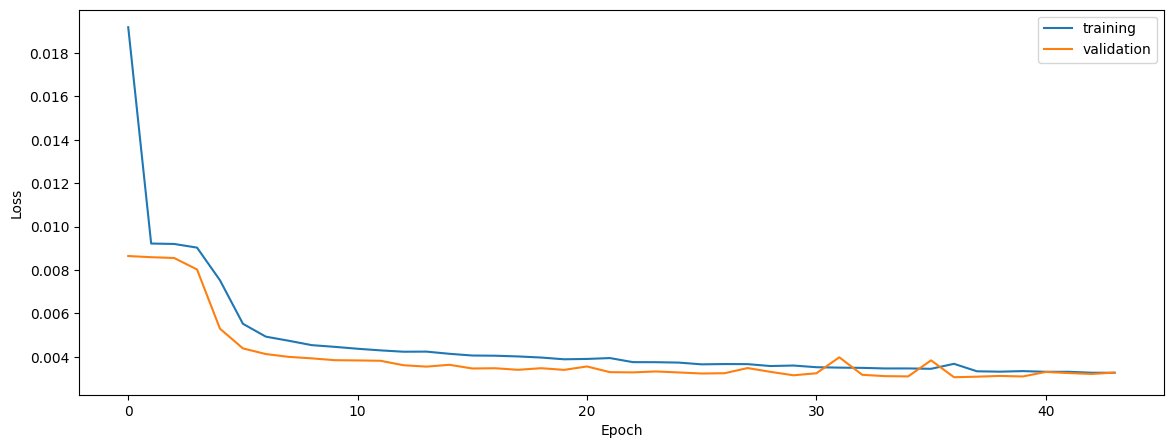

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


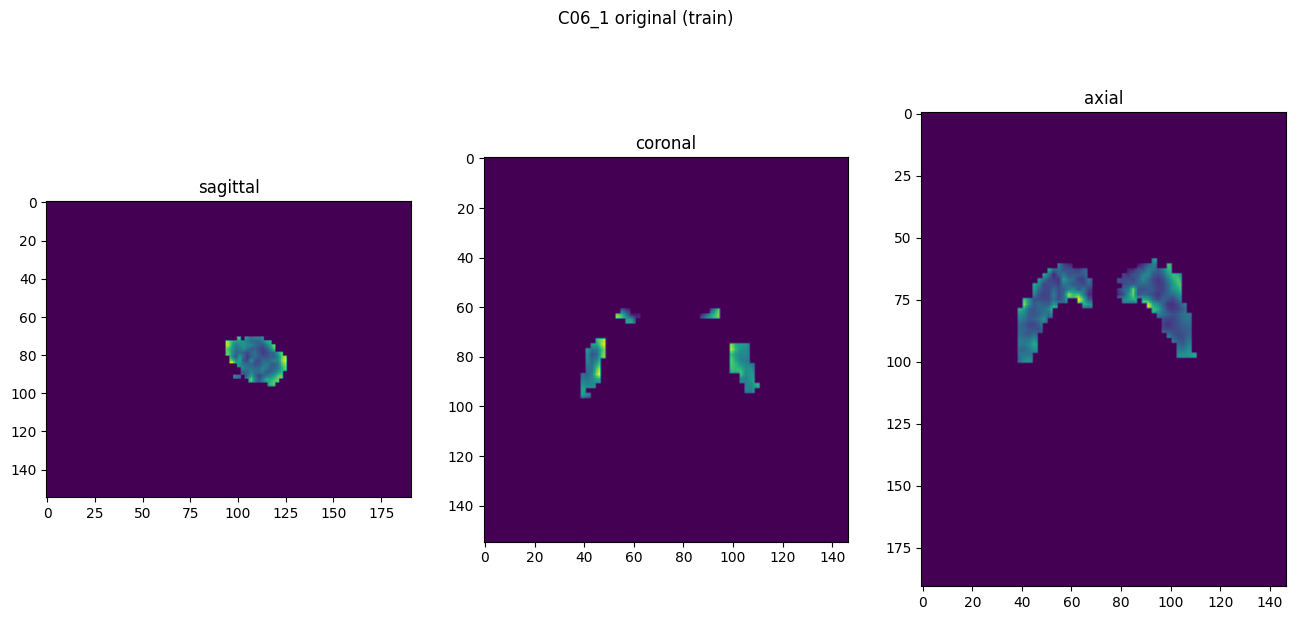

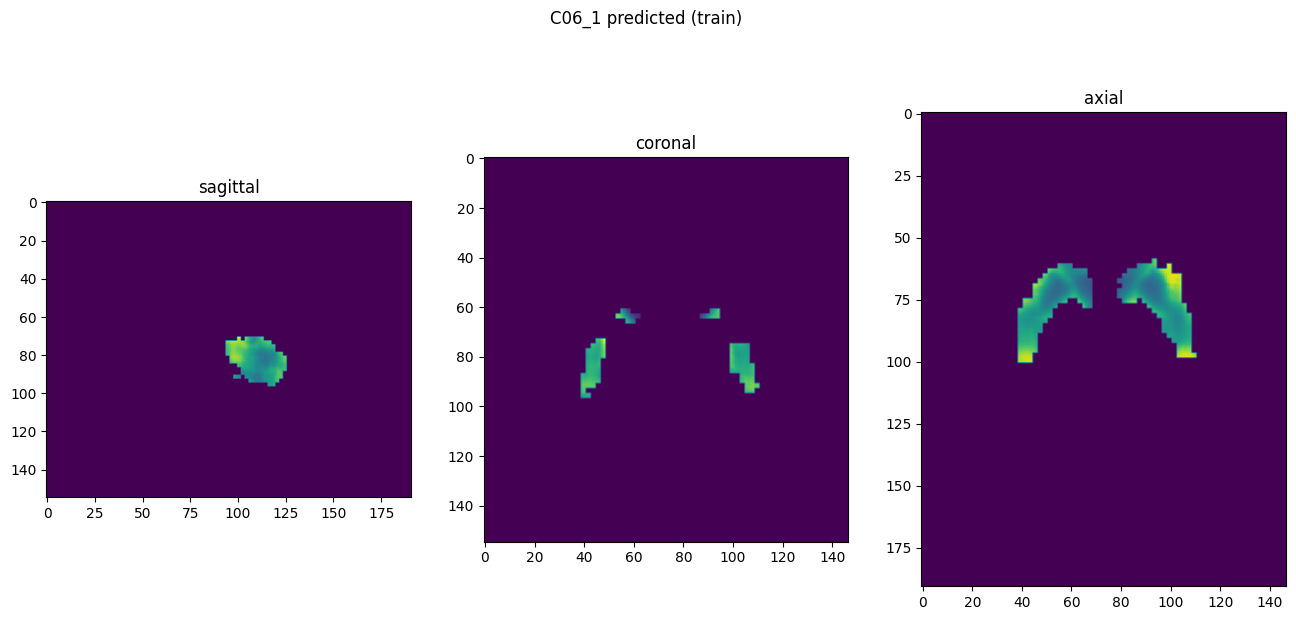

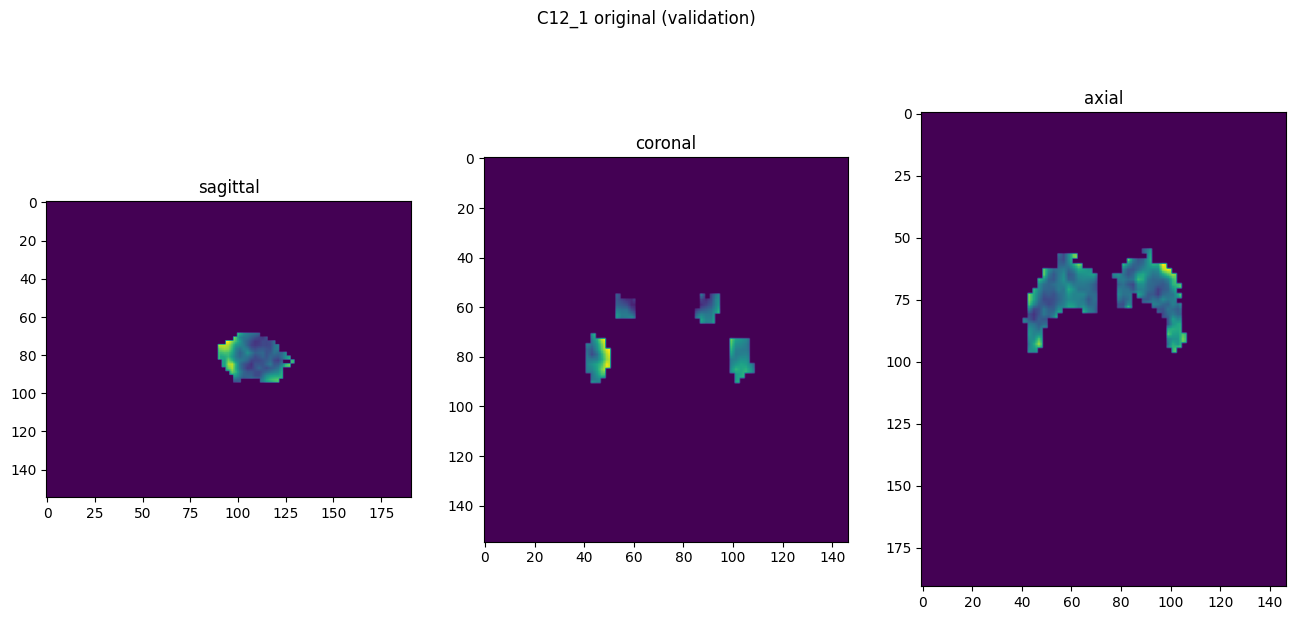

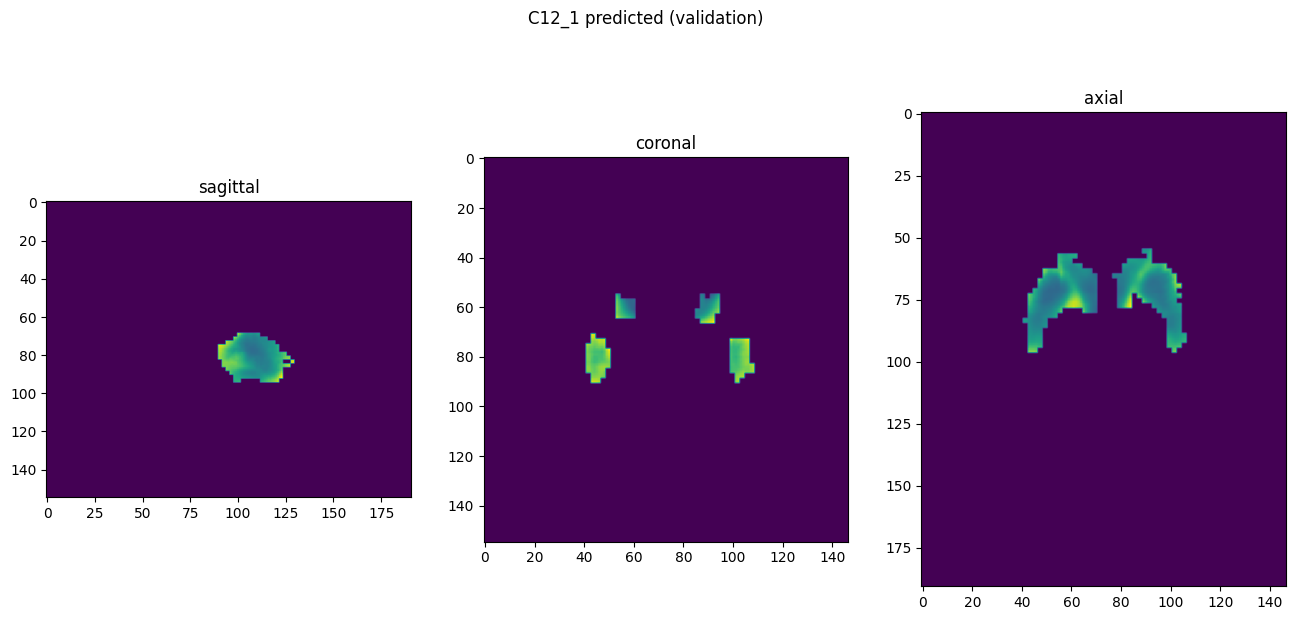

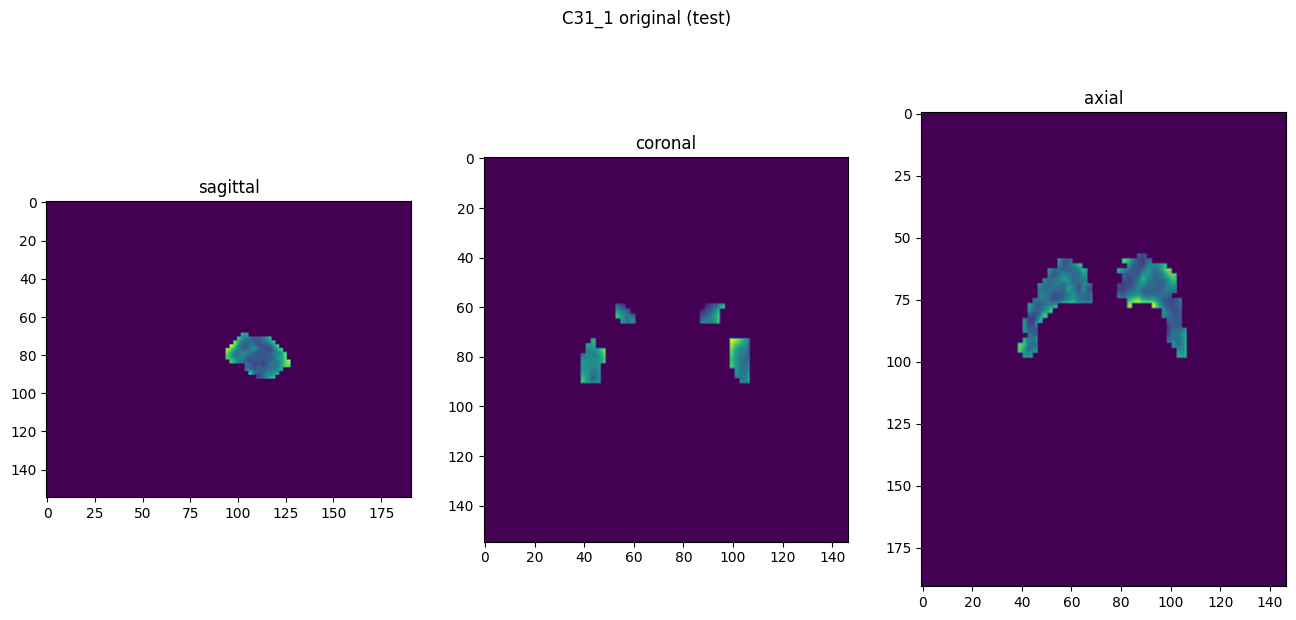

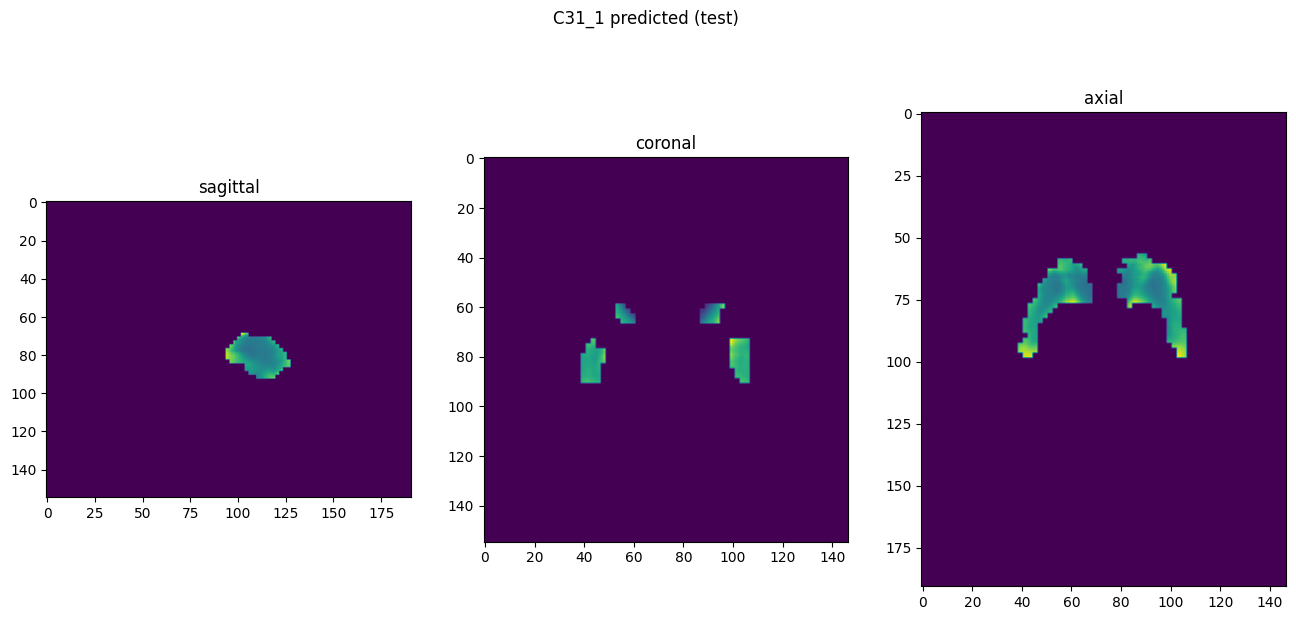

In [10]:
showResults(model, gen, threshold=None, background=False)